 # Install Stable-baselines/ TensorTrade - Colab

In [1]:
#install stable-baselines
!sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev

# setup dependencies
# !python3 -m pip install git+https://github.com/tensortrade-org/tensortrade.git
!python3 -m pip install git+https://github.com/essamabas/tensortrade.git@live
!pip install yfinance ta matplotlib s3fs

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,699 kB]
Fetched 1,714 kB in 2s (899 

In [2]:
!pip install stable-baselines[mpi]==2.10.1
#select tensorflow version 1. - 
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import stable_baselines
stable_baselines.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'2.10.1'

# Log to Google-Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
os.chdir("/content/drive/MyDrive/instruments")
os.getcwd()

'/content/drive/MyDrive/instruments'

# Include Libraries

In [8]:
# setup dependencies
import inspect
import sys
import os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
#sys.path.insert(0, "{}".format(parentdir))
currentdir

'/content/drive/MyDrive/instruments'

In [9]:
import pandas as pd
import tensortrade.env.default as default

from tensortrade.data.cdd import CryptoDataDownload
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
# Make a stream of closing prices to make orders on
from tensortrade.oms.instruments import USD, Instrument, Quantity
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.agents import DQNAgent
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger, MatplotlibTradingChart


import gym
from stable_baselines.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines import DQN, PPO2, A2C
from stable_baselines.gail import generate_expert_traj

import ta
import numpy as np
from datetime import datetime

from scipy.signal import argrelextrema
import numpy as np

import yfinance as yf

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# silence warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Use these commands - to reload sources, while development
%load_ext autoreload
%autoreload 2

# Helper Functions

In [10]:
def download_data(symbol: str, 
                  start_date: str, 
                  end_date: str = datetime.today().strftime('%Y-%m-%d'),
                  plot: bool = False) -> pd.DataFrame:
    # download Data
    df = yf.download(symbol, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df.columns = [name.lower() for name in df.columns]
    df.drop(columns=["adj close","volume"],inplace=True)
    df.set_index("date",inplace=True)
    if plot:
      df['close'].plot()

    return df

## Apply Technical-Indicators (TA)
#- Check https://github.com/bukosabino/ta
#- TA- Visualization: https://github.com/bukosabino/ta/blob/master/examples_to_use/visualize_features.ipynb
def add_custom_ta_features(
    df: pd.DataFrame,
    open: str,  # noqa
    high: str,
    low: str,
    close: str,
    fillna: bool = False,
    colprefix: str = "",
    apply_pct: bool = False,
    plot: bool = False,
) -> pd.DataFrame:

    # Add Volatility TA
    df = ta.add_volatility_ta(
        df=df, high=high, low=low, close=close, fillna=fillna, colprefix=colprefix
    )
    # Add Trend TA
    df = ta.add_trend_ta(
        df=df, high=high, low=low, close=close, fillna=fillna, colprefix=colprefix
    )
    # Add Other TA
    df = ta.add_others_ta(df=df, close=close, fillna=fillna, colprefix=colprefix)

    # convert to pct
    if apply_pct:
      df = df.pct_change(fill_method ='ffill')
      df = df.applymap(lambda x: x*100)
      df.replace([np.inf, -np.inf], np.nan,inplace=True)
    df.astype(np.float32)    
    df = df.round(5)

    if fillna: 
      df.fillna(value=0,inplace=True)

    if plot:
      fig = make_subplots(rows=5, cols=1,
                          shared_xaxes=True,
                          vertical_spacing=0.02,
                          subplot_titles=("Close", "Bollinger Bands","MACD"))

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['close'],
          name = symbol
      ), row=1, col=1)

      # Bollinger-Bands
      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['close'],
          name = symbol
      ), row=2, col=1)

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['volatility_bbh'],
          name = symbol+' High BB'
      ), row=2, col=1)

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['volatility_bbl'],
          name = symbol+' Low BB'
      ), row=2, col=1)

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['volatility_bbm'],
          name = symbol+' EMA BB' 
      ), row=2, col=1)

      # MACD
      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['trend_macd'],
          name = symbol+' MACD'
      ), row=3, col=1)

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['trend_macd_signal'],
          name = symbol+' MACD Signal'
      ), row=3, col=1)

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['trend_macd_diff'],
          name = symbol+' MACD Difference'
      ), row=3, col=1)

      # SMA
      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['close'],
          name = symbol
      ), row=4, col=1)

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['trend_sma_fast'],
          name = symbol+' SMA-Fast'
      ), row=4, col=1)

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['trend_sma_slow'],
          name = symbol+' SMA-Slow'
      ), row=4, col=1)

      # EMA
      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['close'],
          name = symbol
      ), row=5, col=1)

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['trend_ema_fast'],
          name = symbol+' EMA-Fast'
      ), row=5, col=1)

      fig.add_trace(go.Scatter(
          x=df.index,
          y=df['trend_ema_slow'],
          name = symbol+' EMA-Slow'
      ), row=5, col=1)              

      config = {'displayModeBar': False}
      fig.show(config=config)
     
    return df



def __classify(self, current_index,df_min,df_max):
    '''
    Apply Local/Min - Max analysis
    '''
    if current_index in df_min.index:
        return 1 # buy-decision
    elif current_index in df_max.index:
        return -1 # sell-decision
    else:  # otherwise... it's a 0!
        return 0  # hold-decision

def find_loc_min_max(data: pd.DataFrame, 
                     order_of_points=7,
                     symbol: str = "symbol",
                     plot:bool = False):
    '''
      Find local peaks
    '''
    df_min_ts = data.iloc[argrelextrema(data.org_close.values, np.less_equal, order=order_of_points)[0]].astype(np.float32)
    df_max_ts = data.iloc[argrelextrema(data.org_close.values, np.greater_equal, order=order_of_points)[0]].astype(np.float32)

    df_min_ts = df_min_ts.iloc[:, 0:5]
    df_max_ts = df_max_ts.iloc[:, 0:5]

    if plot:
      fig = go.Figure(data= go.Scatter(
          x=data.index,
          y=data['org_close'],
          name = symbol
      ))
      #fig = go.Figure([go.Scatter(x=df['Date'], y=df['AAPL.High'])])                
      fig.add_trace(go.Scatter(mode="markers", x=df_min_ts.index, y=df_min_ts['org_close'], name="min",marker_color='rgba(0, 255, 0, .9)'))
      fig.add_trace(go.Scatter(mode="markers", x=df_max_ts.index, y=df_max_ts['org_close'], name="max",marker_color='rgba(255, 0, 0, .9)'))

      config = {'displayModeBar': False}
      fig.show(config=config)


    return df_min_ts, df_max_ts

def create_trade_env(quotes, observations ,symbol):

  # Add features
  features = []
  #exclude "date/Column [0]" from observation - start from column 1
  for c in data.columns[0:]:
      s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
      features += [s]
  feed = DataFeed(features)
  feed.compile()

  # define exchange - needs to specify Price-Quote Stream
  exchange  = Exchange("sim-exchange", service=execute_order)(
      Stream.source(list(quotes["close"]), dtype="float").rename(str("USD-{}").format(symbol))
  )

  # add current cash, initial-asset
  cash = Wallet(exchange, 100000 * USD)
  asset = Wallet(exchange, 0 * Instrument(symbol, 2, symbol))

  # initialize portfolio - base currency USD
  portfolio = Portfolio(
      base_instrument = USD, 
      wallets = [
          cash,
          asset
      ]
  )

  # add element for rendered feed
  renderer_feed = DataFeed([
      Stream.source(list(data.index)).rename("date"),
      Stream.source(list(data["open"]), dtype="float").rename("open"),
      Stream.source(list(data["high"]), dtype="float").rename("high"),
      Stream.source(list(data["low"]), dtype="float").rename("low"),
      Stream.source(list(data["close"]), dtype="float").rename("close")
      #Stream.source(list(data["volume"]), dtype="float").rename("volume") 
  ])

  # define reward-scheme
  reward_scheme = default.rewards.SimpleProfit()

  # define action-scheme
  action_scheme = default.actions.BSH(
      cash=cash,
      asset=asset
  )

  # create env
  env = default.create(
      portfolio=portfolio,
      action_scheme=action_scheme,
      reward_scheme=reward_scheme,
      feed=feed,
      renderer_feed=renderer_feed,
      #renderer="screen-log",
      #window_size=20,
      max_allowed_loss=0.6
  )

  return env

def evaluate_model(model, env, num_steps=1000):
  """
  Evaluate a RL agent
  :param model: (BaseRLModel object) the RL Agent
  :param env: Trading-Env to be used
  :param num_steps: (int) number of timesteps to evaluate it
  :return: (float) Mean reward for the last 100 episodes
  """
  episode_rewards = [0.0]
  obs = env.reset()
  done = False
  while not done:
      # _states are only useful when using LSTM policies
      action, _states = model.predict(obs)
      obs, reward, done, info = env.step(action)
      # Stats
      episode_rewards[-1] += reward

  # Compute mean reward for the last 100 episodes
  mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)
  print("Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))
  
  return mean_100ep_reward      

# Here the expert is a random agent
# but it can be any python function, e.g. a PID controller
def expert_trader(_obs, debug_info:bool = False):
    """
    Random agent. It samples actions randomly
    from the action space of the environment.

    :param _obs: (np.ndarray) Current observation
    :return: (np.ndarray) action taken by the expert
    """
    global df_min_ts
    global df_max_ts
    global global_last_action
    global global_buy_counter
    global global_sell_counter

    if debug_info:
      print("obs:=", _obs[0][0],_obs[0][1],_obs[0][2],_obs[0][3])

    # use df_min_ts.iloc[:, 1] to access columns by indices to match observations arrays
    is_buy_action = not (df_min_ts.loc[(df_min_ts.iloc[:, 0] == _obs[0][0]) & 
           (df_min_ts.iloc[:, 1] == _obs[0][1])  &
           (df_min_ts.iloc[:, 2] == _obs[0][2])  &
           (df_min_ts.iloc[:, 3] == _obs[0][3])
    ].empty)

    is_sell_action = not (df_max_ts.loc[(df_max_ts.iloc[:, 0] == _obs[0][0]) & 
           (df_max_ts.iloc[:, 1] == _obs[0][1])  &
           (df_max_ts.iloc[:, 2] == _obs[0][2])  &
           (df_max_ts.iloc[:, 3] == _obs[0][3])
        ].empty)

    if is_buy_action:
        #perform buy action
        global_last_action = 1
        global_buy_counter += 1
        if debug_info:
          print("buy-action",global_buy_counter)
    elif is_sell_action:
        #perform sell action
        global_last_action = 0
        global_sell_counter += 1
        if debug_info:
          print("sell-action",global_sell_counter)
    else:
        #do nothing
        pass

    return global_last_action

## Expert DataSet

In [11]:
# %%
import queue
import time
from multiprocessing import Queue, Process

import cv2  # pytype:disable=import-error
import numpy as np
from joblib import Parallel, delayed
from stable_baselines import logger


class ExpertDataset(object):
    """
    Dataset for using behavior cloning or GAIL.

    The structure of the expert dataset is a dict, saved as an ".npz" archive.
    The dictionary contains the keys 'actions', 'episode_returns', 'rewards', 'obs' and 'episode_starts'.
    The corresponding values have data concatenated across episode: the first axis is the timestep,
    the remaining axes index into the data. In case of images, 'obs' contains the relative path to
    the images, to enable space saving from image compression.

    :param expert_path: (str) The path to trajectory data (.npz file). Mutually exclusive with traj_data.
    :param traj_data: (dict) Trajectory data, in format described above. Mutually exclusive with expert_path.
    :param train_fraction: (float) the train validation split (0 to 1)
        for pre-training using behavior cloning (BC)
    :param batch_size: (int) the minibatch size for behavior cloning
    :param traj_limitation: (int) the number of trajectory to use (if -1, load all)
    :param randomize: (bool) if the dataset should be shuffled
    :param verbose: (int) Verbosity
    :param sequential_preprocessing: (bool) Do not use subprocess to preprocess
        the data (slower but use less memory for the CI)
    """
    # Excluded attribute when pickling the object
    EXCLUDED_KEYS = {'dataloader', 'train_loader', 'val_loader'}

    def __init__(self, expert_path=None, traj_data=None, train_fraction=0.7, batch_size=64,
                 traj_limitation=-1, randomize=True, verbose=1, sequential_preprocessing=False):
        if traj_data is not None and expert_path is not None:
            raise ValueError("Cannot specify both 'traj_data' and 'expert_path'")
        if traj_data is None and expert_path is None:
            raise ValueError("Must specify one of 'traj_data' or 'expert_path'")
        if traj_data is None:
            traj_data = np.load(expert_path, allow_pickle=True)

        if verbose > 0:
            for key, val in traj_data.items():
                print(key, val.shape)

        # Array of bool where episode_starts[i] = True for each new episode
        episode_starts = traj_data['episode_starts']

        traj_limit_idx = len(traj_data['obs'])

        if traj_limitation > 0:
            n_episodes = 0
            # Retrieve the index corresponding
            # to the traj_limitation trajectory
            for idx, episode_start in enumerate(episode_starts):
                n_episodes += int(episode_start)
                if n_episodes == (traj_limitation + 1):
                    traj_limit_idx = idx - 1

        observations = traj_data['obs'][:traj_limit_idx]
        actions = traj_data['actions'][:traj_limit_idx]

        # obs, actions: shape (N * L, ) + S
        # where N = # episodes, L = episode length
        # and S is the environment observation/action space.
        # S = (1, ) for discrete space
        # Flatten to (N * L, prod(S))
        if len(observations.shape) > 2:
            #observations = np.reshape(observations, [-1, np.prod(observations.shape[1:])])
            pass
        if len(actions.shape) > 2:
            #actions = np.reshape(actions, [-1, np.prod(actions.shape[1:])])
            pass

        indices = np.random.permutation(len(observations)).astype(np.int64)

        # Train/Validation split when using behavior cloning
        train_indices = indices[:int(train_fraction * len(indices))]
        val_indices = indices[int(train_fraction * len(indices)):]

        assert len(train_indices) > 0, "No sample for the training set"
        assert len(val_indices) > 0, "No sample for the validation set"

        self.observations = observations
        self.actions = actions

        self.returns = traj_data['episode_returns'][:traj_limit_idx]
        self.avg_ret = sum(self.returns) / len(self.returns)
        self.std_ret = np.std(np.array(self.returns))
        self.verbose = verbose

        assert len(self.observations) == len(self.actions), "The number of actions and observations differ " \
                                                            "please check your expert dataset"
        self.num_traj = min(traj_limitation, np.sum(episode_starts))
        self.num_transition = len(self.observations)
        self.randomize = randomize
        self.sequential_preprocessing = sequential_preprocessing

        self.dataloader = None
        self.train_loader = DataLoader(train_indices, self.observations, self.actions, batch_size,
                                       shuffle=self.randomize, start_process=False,
                                       sequential=sequential_preprocessing)
        self.val_loader = DataLoader(val_indices, self.observations, self.actions, batch_size,
                                     shuffle=self.randomize, start_process=False,
                                     sequential=sequential_preprocessing)

        if self.verbose >= 1:
            self.log_info()

    def init_dataloader(self, batch_size):
        """
        Initialize the dataloader used by GAIL.

        :param batch_size: (int)
        """
        indices = np.random.permutation(len(self.observations)).astype(np.int64)
        self.dataloader = DataLoader(indices, self.observations, self.actions, batch_size,
                                     shuffle=self.randomize, start_process=False,
                                     sequential=self.sequential_preprocessing)

    def __del__(self):
        # Exit processes if needed
        for key in self.EXCLUDED_KEYS:
            if self.__dict__.get(key) is not None:
                del self.__dict__[key]

    def __getstate__(self):
        """
        Gets state for pickling.

        Excludes processes that are not pickleable
        """
        # Remove processes in order to pickle the dataset.
        return {key: val for key, val in self.__dict__.items() if key not in self.EXCLUDED_KEYS}

    def __setstate__(self, state):
        """
        Restores pickled state.

        init_dataloader() must be called
        after unpickling before using it with GAIL.

        :param state: (dict)
        """
        self.__dict__.update(state)
        for excluded_key in self.EXCLUDED_KEYS:
            assert excluded_key not in state
        self.dataloader = None
        self.train_loader = None
        self.val_loader = None

    def log_info(self):
        """
        Log the information of the dataset.
        """
        logger.log("Total trajectories: {}".format(self.num_traj))
        logger.log("Total transitions: {}".format(self.num_transition))
        logger.log("Average returns: {}".format(self.avg_ret))
        logger.log("Std for returns: {}".format(self.std_ret))

    def get_next_batch(self, split=None):
        """
        Get the batch from the dataset.

        :param split: (str) the type of data split (can be None, 'train', 'val')
        :return: (np.ndarray, np.ndarray) inputs and labels
        """
        dataloader = {
            None: self.dataloader,
            'train': self.train_loader,
            'val': self.val_loader
        }[split]

        if dataloader.process is None:
            dataloader.start_process()
        try:
            return next(dataloader)
        except StopIteration:
            dataloader = iter(dataloader)
            return next(dataloader)

    def plot(self):
        """
        Show histogram plotting of the episode returns
        """
        # Isolate dependency since it is only used for plotting and also since
        # different matplotlib backends have further dependencies themselves.
        import matplotlib.pyplot as plt
        plt.hist(self.returns)
        plt.show()


class DataLoader(object):
    """
    A custom dataloader to preprocessing observations (including images)
    and feed them to the network.

    Original code for the dataloader from https://github.com/araffin/robotics-rl-srl
    (MIT licence)
    Authors: Antonin Raffin, René Traoré, Ashley Hill

    :param indices: ([int]) list of observations indices
    :param observations: (np.ndarray) observations or images path
    :param actions: (np.ndarray) actions
    :param batch_size: (int) Number of samples per minibatch
    :param n_workers: (int) number of preprocessing worker (for loading the images)
    :param infinite_loop: (bool) whether to have an iterator that can be reset
    :param max_queue_len: (int) Max number of minibatches that can be preprocessed at the same time
    :param shuffle: (bool) Shuffle the minibatch after each epoch
    :param start_process: (bool) Start the preprocessing process (default: True)
    :param backend: (str) joblib backend (one of 'multiprocessing', 'sequential', 'threading'
        or 'loky' in newest versions)
    :param sequential: (bool) Do not use subprocess to preprocess the data
        (slower but use less memory for the CI)
    :param partial_minibatch: (bool) Allow partial minibatches (minibatches with a number of element
        lesser than the batch_size)
    """

    def __init__(self, indices, observations, actions, batch_size, n_workers=1,
                 infinite_loop=True, max_queue_len=1, shuffle=False,
                 start_process=True, backend='threading', sequential=False, partial_minibatch=True):
        super(DataLoader, self).__init__()
        self.n_workers = n_workers
        self.infinite_loop = infinite_loop
        self.indices = indices
        self.original_indices = indices.copy()
        self.n_minibatches = len(indices) // batch_size
        # Add a partial minibatch, for instance
        # when there is not enough samples
        if partial_minibatch and len(indices) % batch_size > 0:
            self.n_minibatches += 1
        self.batch_size = batch_size
        self.observations = observations
        self.actions = actions
        self.shuffle = shuffle
        self.queue = Queue(max_queue_len)
        self.process = None
        self.load_images = isinstance(observations[0], str)
        self.backend = backend
        self.sequential = sequential
        self.start_idx = 0
        if start_process:
            self.start_process()

    def start_process(self):
        """Start preprocessing process"""
        # Skip if in sequential mode
        if self.sequential:
            return
        self.process = Process(target=self._run)
        # Make it a deamon, so it will be deleted at the same time
        # of the main process
        self.process.daemon = True
        self.process.start()

    @property
    def _minibatch_indices(self):
        """
        Current minibatch indices given the current pointer
        (start_idx) and the minibatch size
        :return: (np.ndarray) 1D array of indices
        """
        return self.indices[self.start_idx:self.start_idx + self.batch_size]

    def sequential_next(self):
        """
        Sequential version of the pre-processing.
        """
        if self.start_idx > len(self.indices):
            raise StopIteration

        if self.start_idx == 0:
            if self.shuffle:
                # Shuffle indices
                np.random.shuffle(self.indices)

        obs = self.observations[self._minibatch_indices]
        if self.load_images:
            obs = np.concatenate([self._make_batch_element(image_path) for image_path in obs],
                                 axis=0)

        actions = self.actions[self._minibatch_indices]
        self.start_idx += self.batch_size
        return obs, actions

    def _run(self):
        start = True
        with Parallel(n_jobs=self.n_workers, batch_size="auto", backend=self.backend) as parallel:
            while start or self.infinite_loop:
                start = False

                if self.shuffle:
                    np.random.shuffle(self.indices)

                for minibatch_idx in range(self.n_minibatches):

                    self.start_idx = minibatch_idx * self.batch_size

                    obs = self.observations[self._minibatch_indices]
                    if self.load_images:
                        if self.n_workers <= 1:
                            obs = [self._make_batch_element(image_path)
                                   for image_path in obs]

                        else:
                            obs = parallel(delayed(self._make_batch_element)(image_path)
                                           for image_path in obs)

                        obs = np.concatenate(obs, axis=0)

                    actions = self.actions[self._minibatch_indices]

                    self.queue.put((obs, actions))

                    # Free memory
                    del obs

                self.queue.put(None)

    @classmethod
    def _make_batch_element(cls, image_path):
        """
        Process one element.

        :param image_path: (str) path to an image
        :return: (np.ndarray)
        """
        # cv2.IMREAD_UNCHANGED is needed to load
        # grey and RGBa images
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        # Grey image
        if len(image.shape) == 2:
            image = image[:, :, np.newaxis]

        if image is None:
            raise ValueError("Tried to load {}, but it was not found".format(image_path))
        # Convert from BGR to RGB
        if image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.reshape((1,) + image.shape)
        return image

    def __len__(self):
        return self.n_minibatches

    def __iter__(self):
        self.start_idx = 0
        self.indices = self.original_indices.copy()
        return self

    def __next__(self):
        if self.sequential:
            return self.sequential_next()

        if self.process is None:
            raise ValueError("You must call .start_process() before using the dataloader")
        while True:
            try:
                val = self.queue.get_nowait()
                break
            except queue.Empty:
                time.sleep(0.001)
                continue
        if val is None:
            raise StopIteration
        return val

    def __del__(self):
        if self.process is not None:
            self.process.terminate()

 # Trading Data

[*********************100%***********************]  1 of 1 completed


,open,high,low,close
date,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214
2010-01-05,7.664286,7.699643,7.616071,7.656428
2010-01-06,7.656428,7.686786,7.526786,7.534643
2010-01-07,7.562500,7.571429,7.466072,7.520714
2010-01-08,7.510714,7.571429,7.466429,7.570714


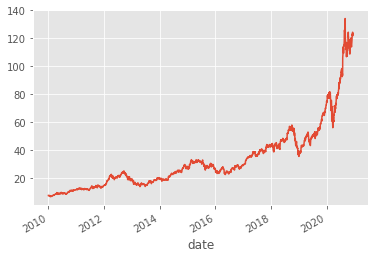

In [12]:
symbol = 'AAPL'
exchange = 'NASDAQ'
start_date = '2010-01-01'
end_date = '2020-12-11'

quotes = download_data(symbol=symbol, start_date=start_date, end_date=end_date, plot=True)
quotes.head()

## Apply Technical-Indicators (TA)
- Check https://github.com/bukosabino/ta
- TA- Visualization: https://github.com/bukosabino/ta/blob/master/examples_to_use/visualize_features.ipynb

In [16]:
# get ta-indicators
data = add_custom_ta_features(quotes,"open","high","low","close", fillna=True,plot=True,apply_pct=False)
data.tail()

,open,high,low,close,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,others_dr,others_dlr,others_cr
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-04,122.60,122.86,121.52,122.25,2.75055,118.7160,123.87856,113.55344,8.69733,0.84227,0.0,0.0,118.88033,121.32733,116.43333,4.11675,1.18853,1.0,0.0,112.59,123.78,118.185,9.42586,0.86327,2.43016,1.49570,0.91065,0.58505,118.80750,117.37269,119.83166,118.33596,14.69996,28.20298,19.78314,1.06369,0.86566,0.19803,0.10754,23.83564,128.55789,-0.6860,26.96771,22.03982,4.92789,118.185,115.550,116.8675,115.195,115.7600,120.54,92.0,8.0,84.0,113.45121,121.4372,0.0,0.0,77.67659,-0.56125,-0.56283,1499.45798
2020-12-07,122.31,124.57,122.25,123.75,2.70749,118.9690,124.57829,113.35971,9.42983,0.92617,0.0,0.0,119.45267,121.98367,116.92167,4.23766,1.34894,1.0,0.0,112.59,124.57,118.580,10.06985,0.93155,2.43016,1.69748,1.06802,0.62947,119.28417,117.69692,120.43448,118.73700,15.40325,30.79465,18.65639,1.07790,0.85215,0.22575,0.12604,23.66001,149.03655,-0.3290,28.04861,22.59775,5.45087,118.580,115.945,117.2625,115.195,115.4775,120.54,100.0,4.0,96.0,113.86436,121.4372,0.0,0.0,88.83830,1.22699,1.21953,1519.08323
2020-12-08,124.37,124.98,123.09,124.38,2.62575,119.3720,125.31059,113.43341,9.94971,0.92165,0.0,0.0,120.36033,122.69333,118.02733,3.87670,1.36148,1.0,0.0,112.59,124.98,118.785,10.37932,0.95157,2.42173,1.88648,1.23171,0.65477,119.76250,118.29385,121.04149,119.15500,16.17191,30.36151,17.76853,1.07836,0.83158,0.24678,0.14559,23.51196,142.45793,-2.0320,32.61446,23.54882,9.06564,120.075,116.150,118.1125,116.355,114.9400,120.54,100.0,4.0,96.0,114.50670,121.4372,0.0,0.0,94.41915,0.50909,0.50780,1527.32580
2020-12-09,124.53,125.95,121.00,121.78,2.85817,119.6625,125.47406,113.85094,9.71325,0.68218,0.0,0.0,121.19767,123.69967,118.69567,4.12879,0.61637,0.0,0.0,112.59,125.95,119.270,11.16473,0.68787,2.43364,1.80566,1.34650,0.45916,120.13250,118.79423,121.15510,119.34945,15.93631,26.76845,20.66244,1.04152,0.79695,0.24458,0.16033,23.61321,94.64082,-5.8125,34.38862,24.99215,9.39647,121.085,117.340,119.2125,116.635,114.6850,120.54,96.0,56.0,40.0,115.34456,121.4372,0.0,0.0,97.20957,-2.09037,-2.11252,1493.30872
2020-12-10,120.50,123.87,120.15,123.24,2.94435,119.8500,125.86559,113.83441,10.03853,0.78177,0.0,0.0,121.84133,124.55733,119.12533,4.45826,0.75749,0.0,0.0,112.59,125.95,119.270,11.14727,0.79716,2.41797,1.83822,1.44484,0.39338,120.91500,119.28654,121.47586,119.63763,15.36194,24.42872,20.85360,1.04871,0.83866,0.21005,0.17332,23.76349,71.78391,-4.6800,37.83665,27.31145,10.52519,121.380,119.150,120.2650,116.635,114.5175,120.54,92.0,52.0,40.0,116.40511,121.4372,0.0,0.0,98.60479,1.19888,1.19175,1512.41062


## Get Local Minima/Maxima


In [17]:
# get Min/Max TimeStamps
tmp_data = data.iloc[:,0:4]
tmp_data['org_close'] = quotes['close']
df_min_ts, df_max_ts = find_loc_min_max(data=tmp_data,order_of_points=7, plot=True)
df_min_ts.head()

,open,high,low,close,org_close
date,,,,,
2010-02-04,7.02607,7.08464,6.84179,6.85893,6.858929
2010-02-23,7.14286,7.19036,6.98964,7.03786,7.037857
2010-03-19,8.02821,8.04429,7.90107,7.93750,7.937500
2010-05-07,8.70393,8.80607,8.04321,8.42357,8.423572
2010-05-20,8.63857,8.70893,8.43607,8.49143,8.491428


In [15]:
i = 0
for index in quotes.index:
  print("index:=", index)
  if index in df_min_ts.index.values:
    if i==0:
      df_min = quotes.iloc[lambda x:x.index == index]
      i += 1
    else:
      df_min.append(quotes.iloc[lambda x:x.index == index])

df_min

index:= 2010-01-04 00:00:00
index:= 2010-01-05 00:00:00
index:= 2010-01-06 00:00:00
index:= 2010-01-07 00:00:00
index:= 2010-01-08 00:00:00
index:= 2010-01-11 00:00:00
index:= 2010-01-12 00:00:00
index:= 2010-01-13 00:00:00
index:= 2010-01-14 00:00:00
index:= 2010-01-15 00:00:00
index:= 2010-01-19 00:00:00
index:= 2010-01-20 00:00:00
index:= 2010-01-21 00:00:00
index:= 2010-01-22 00:00:00
index:= 2010-01-25 00:00:00
index:= 2010-01-26 00:00:00
index:= 2010-01-27 00:00:00
index:= 2010-01-28 00:00:00
index:= 2010-01-29 00:00:00
index:= 2010-02-01 00:00:00
index:= 2010-02-02 00:00:00
index:= 2010-02-03 00:00:00
index:= 2010-02-04 00:00:00
index:= 2010-02-05 00:00:00
index:= 2010-02-08 00:00:00
index:= 2010-02-09 00:00:00
index:= 2010-02-10 00:00:00
index:= 2010-02-11 00:00:00
index:= 2010-02-12 00:00:00
index:= 2010-02-16 00:00:00
index:= 2010-02-17 00:00:00
index:= 2010-02-18 00:00:00
index:= 2010-02-19 00:00:00
index:= 2010-02-22 00:00:00
index:= 2010-02-23 00:00:00
index:= 2010-02-24 0

,open,high,low,close,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,others_dr,others_dlr,others_cr
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-04,7.026072,7.084643,6.841786,6.858929,0.237346,7.301964,7.799632,6.804296,13.63107,0.054888,0.0,0.0,7.121452,7.392881,6.850024,7.622842,0.016404,0.0,0.0,6.794643,7.698214,7.246428,12.374357,0.071146,6.855598,-0.164363,-0.123467,-0.040895,7.165655,7.342329,7.137686,7.302049,0.0,14.07458,27.911019,0.771368,1.041411,-0.270043,-0.233566,27.441336,-125.08844,0.259821,-531.937115,-645.235474,113.298359,7.213572,7.247143,7.230357,7.247143,32.862564,32.157352,44.0,92.0,-48.0,7.313247,7.508491,0.0,0.0,0.090174,-3.60387,-3.670413,-10.261201


# Create Trading-Enviornment

In [18]:
env = create_trade_env(quotes, data,symbol)

In [19]:
env.observer.feed.next()

{'external': {'close': 7.64321,
  'high': 7.66071,
  'low': 7.585,
  'open': 7.6225,
  'others_cr': 0.0,
  'others_dlr': 0.0,
  'others_dr': -77.04046,
  'trend_adx': 0.0,
  'trend_adx_neg': 0.0,
  'trend_adx_pos': 0.0,
  'trend_aroon_down': 4.0,
  'trend_aroon_ind': 0.0,
  'trend_aroon_up': 4.0,
  'trend_cci': 0.0,
  'trend_dpo': 25.64671,
  'trend_ema_fast': 7.64321,
  'trend_ema_slow': 7.64321,
  'trend_ichimoku_a': 7.62286,
  'trend_ichimoku_b': 7.62286,
  'trend_ichimoku_base': 7.62286,
  'trend_ichimoku_conv': 7.62286,
  'trend_kst': -770.4046,
  'trend_kst_diff': 0.0,
  'trend_kst_sig': -770.4046,
  'trend_macd': 0.0,
  'trend_macd_diff': 0.0,
  'trend_macd_signal': 0.0,
  'trend_mass_index': 1.0,
  'trend_psar_down': -1.0,
  'trend_psar_down_indicator': 0.0,
  'trend_psar_up': -1.0,
  'trend_psar_up_indicator': 0.0,
  'trend_sma_fast': 7.64321,
  'trend_sma_slow': 7.64321,
  'trend_stc': 0.0,
  'trend_trix': -76.43948,
  'trend_visual_ichimoku_a': 32.86256,
  'trend_visual_ichi

# Generate Expert Records

In [20]:
# ## Generate Expert Trajectories
import gym

global_buy_counter = 0
global_sell_counter = 0
global_last_action = 0



# The algorithms require a vectorized environment to run

# Data will be saved in a numpy archive named `expert_cartpole.npz`
# when using something different than an RL expert,
# you must pass the environment object explicitly
# Automatically normalize the input features and reward
#VecEnv = DummyVecEnv([lambda: create_trade_env(data,symbol)])
# Automatically normalize the input features and reward
#VecEnv = VecNormalize(VecEnv, norm_obs=True, norm_reward=True,
#                   clip_obs=10.)
generate_expert_traj(expert_trader, 'expert_trader_ORG_'+symbol, env, n_episodes=10)

actions (27540, 1)
obs (27540, 1, 62)
rewards (27540,)
episode_returns (10,)
episode_starts (27540,)


{'actions': array([[0],
        [0],
        [0],
        ...,
        [1],
        [0],
        [0]]),
 'episode_returns': array([6.11316102, 6.11316102, 6.11316102, 6.11316102, 6.11316102,
        6.11316102, 6.11316102, 6.11316102, 6.11316102, 6.11316102]),
 'episode_starts': array([ True, False, False, ..., False, False, False]),
 'obs': array([[[ 7.6224999e+00,  7.6607099e+00,  7.5850000e+00, ...,
          -7.7040459e+01,  0.0000000e+00,  0.0000000e+00]],
 
        [[ 7.6642900e+00,  7.6996398e+00,  7.6160698e+00, ...,
           1.7288999e-01,  1.7274000e-01,  1.7288999e-01]],
 
        [[ 7.6564298e+00,  7.6867900e+00,  7.5267901e+00, ...,
          -1.5906301e+00, -1.6034200e+00, -1.4205000e+00]],
 
        ...,
 
        [[ 1.2231000e+02,  1.2457000e+02,  1.2225000e+02, ...,
           1.2269900e+00,  1.2195300e+00,  1.5190833e+03]],
 
        [[ 1.2437000e+02,  1.2498000e+02,  1.2309000e+02, ...,
           5.0909001e-01,  5.0779998e-01,  1.5273258e+03]],
 
        [[ 1.2453

# Read Recording Set

actions (27540, 1)
obs (27540, 1, 62)
rewards (27540,)
episode_returns (10,)
episode_starts (27540,)
Total trajectories: 10
Total transitions: 27540
Average returns: 6.113161016522376
Std for returns: 0.0


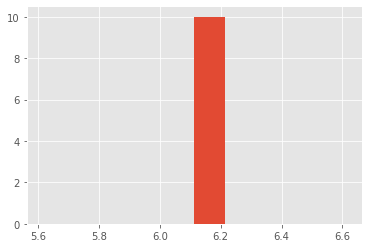

(27540, 1, 62)


In [21]:
# Pre-Train a Model using Behavior Cloning
#import ExpertDataset
# Using only one expert trajectory
# you can specify `traj_limitation=-1` for using the whole dataset
dataset = ExpertDataset(expert_path='expert_trader_ORG_'+ symbol +'.npz',
                        traj_limitation=10, batch_size=64, randomize = False)
dataset.plot()
print(dataset.observations.shape)

# Train RL-Agent using Expert-Records

In [ ]:
# PPO2-Model
from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy

VecEnv = DummyVecEnv([lambda: create_trade_env(quotes, data,symbol)])
agent = PPO2(MlpPolicy, env=VecEnv, verbose=1,tensorboard_log=os.path.join(currentdir,"logs"))
# Pretrain the PPO2 model
agent.pretrain(dataset, n_epochs=1000)

# As an option, you can train the RL agent
agent.learn(int(1e5),tb_log_name="learn_"+symbol)
agent.save(save_path=os.path.join(currentdir, "BC_PPO2_MlpPolicy_NORM.zip"))

Streaming output truncated to the last 5000 lines.
| n_updates          | 195          |
| policy_entropy     | 0.07674407   |
| policy_loss        | -0.014150785 |
| serial_timesteps   | 24960        |
| time_elapsed       | 1.57e+03     |
| total_timesteps    | 24960        |
| value_loss         | 0.0031393645 |
-------------------------------------
-------------------------------------
| approxkl           | 0.15615577   |
| clipfrac           | 0.064453125  |
| explained_variance | -2.34        |
| fps                | 86           |
| n_updates          | 196          |
| policy_entropy     | 0.05997924   |
| policy_loss        | -0.012903938 |
| serial_timesteps   | 25088        |
| time_elapsed       | 1.57e+03     |
| total_timesteps    | 25088        |
| value_loss         | 0.0019942853 |
-------------------------------------
-------------------------------------
| approxkl           | 0.13922267   |
| clipfrac           | 0.095703125  |
| explained_variance | -7.75        |

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs/
#tensorboard = TensorBoard(log_dir="./logs")

 ## Evaluate Model

[*********************100%***********************]  1 of 1 completed


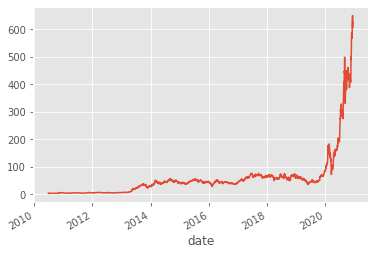

In [ ]:
symbol = 'AACQU'
start_date = '2010-01-01'
end_date = '2020-12-11'
#MSFT, TSLA, AAPL,NFLX,GOOG, GLD
quotes = download_data(symbol=symbol, start_date=start_date, end_date=end_date,plot=True)
data = add_custom_ta_features(quotes,"open","high","low","close", fillna=True)
#df_min_ts, df_max_ts = find_loc_min_max(data=quotes,order_of_points=7, plot=True)
env = create_trade_env(quotes, data,symbol)

In [ ]:
# %%
VecEnv = DummyVecEnv([lambda: create_trade_env(quotes, data,symbol)])
agent = PPO2.load(load_path=os.path.join(currentdir, "BC_PPO2_MlpPolicy_NORM.zip"))
#agent = DQN.load(load_path=os.path.join(currentdir, "agents","DQN_MlpPolicy_02.zip"), env=env)
evaluate_model(agent, env)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Mean reward: 3.9 Num episodes: 1


3.9

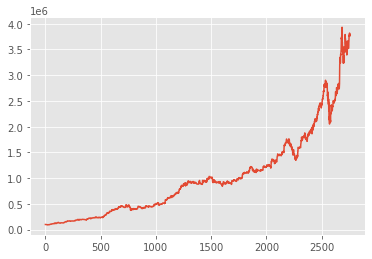

In [ ]:
#portfolio.performance.net_worth.plot()
performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance['net_worth'].plot()

In [ ]:
performance['net_worth'].tail()

2750    2.747363e+07
2751    2.781073e+07
2752    2.795231e+07
2753    2.736800e+07
2754    2.768112e+07
Name: net_worth, dtype: float64

# Load Financial Symbols

In [ ]:
!pip install finsymbols

In [ ]:
from finsymbols import symbols
import json
import pprint

#symbol_list = symbols.get_sp500_symbols()
#symbol_list.extend(symbols.get_amex_symbols())
#symbol_list.extend(symbols.get_nyse_symbols())
#symbol_list.extend(symbols.get_nasdaq_symbols())
symbol_list = symbols.get_nasdaq_symbols()

column_names = ['company','headquarters', 'industry','sector','symbol']
df = pd.DataFrame(symbol_list, columns=column_names)
my_symbols = df['symbol'].replace("\n", "", regex=True)

# Loops

## Create expert Recordings

In [ ]:
# Download List of NASDAQ Insturment
df = pd.read_csv('nasdaq_list.csv')
#df = df.iloc[17:]
df.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
17,ABNB,Airbnb Inc. Class A Common Stock,$139.25,-5.46,-3.773%,8.304856e+10,United States,2020.0,26951761,NaN,NaN
18,ABST,Absolute Software Corporation Common Stock,$10.37,0.18,1.766%,5.058257e+08,Canada,2020.0,116816,Technology,Computer Software: Prepackaged Software
19,ABTX,Allegiance Bancshares Inc. Common Stock,$34.25,-0.07,-0.204%,7.003272e+08,United States,2015.0,55342,Finance,Major Banks
20,ABUS,Arbutus Biopharma Corporation Common Stock,$3.91,0.24,6.54%,3.319952e+08,Canada,NaN,4206501,Health Care,Major Pharmaceuticals
21,ACAC,Acies Acquisition Corp.,NaN,NaN,NaN,NaN,United States,NaN,0,NaN,NaN


In [ ]:
start_date = '2010-01-01'
end_date = '2020-12-11'
for symbol in df['Symbol']:
  #MSFT, TSLA, AAPL,NFLX,GOOG, GLD
  print("symbol:=", symbol)
  quotes = download_data(symbol=symbol, start_date=start_date, end_date=end_date,plot=True)
  if (not quotes.empty) and (len(quotes)>100):
    data = add_custom_ta_features(quotes,"open","high","low","close", fillna=True)
    # get Min/Max TimeStamps
    tmp_data = data.iloc[:,0:4]
    tmp_data['org_close'] = quotes['close']
    df_min_ts, df_max_ts = find_loc_min_max(data=tmp_data,order_of_points=7, plot=True, symbol=symbol)
    env = create_trade_env(quotes, data,symbol)

    global_buy_counter = 0
    global_sell_counter = 0
    global_last_action = 0
    try:
      generate_expert_traj(expert_trader, 'expert_trader_'+symbol, env, n_episodes=10)
    except:
      print("An exception occurred while generating recording for symbol:=",symbol)
    

## Trainning Loop

Streaming output truncated to the last 5000 lines.
| policy_loss        | -0.01758887 |
| serial_timesteps   | 4736        |
| time_elapsed       | 368         |
| total_timesteps    | 4736        |
| value_loss         | 0.01390655  |
------------------------------------
-------------------------------------
| approxkl           | 0.0092435535 |
| clipfrac           | 0.05078125   |
| explained_variance | -10          |
| fps                | 6            |
| n_updates          | 38           |
| policy_entropy     | 0.36255425   |
| policy_loss        | -0.0175619   |
| serial_timesteps   | 4864         |
| time_elapsed       | 387          |
| total_timesteps    | 4864         |
| value_loss         | 0.015295778  |
-------------------------------------
-------------------------------------
| approxkl           | 0.023925204  |
| clipfrac           | 0.076171875  |
| explained_variance | -2.05        |
| fps                | 6            |
| n_updates          | 39           |
| pol

Process Process-36:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-37:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "<ipython-input-12-c5f90e5071c3>", line 315, in _run
    self.queue.put((obs, actions))
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 82, in put
    if not self._sem.acquire(block, timeout):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-12-c5f90e5071c3>", line 315, in _run
    self.queue.put((obs, actions))
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 82, in put
    if not self._sem.acquire(block, timeout):
KeyboardInterrupt


KeyboardInterrupt: ignored

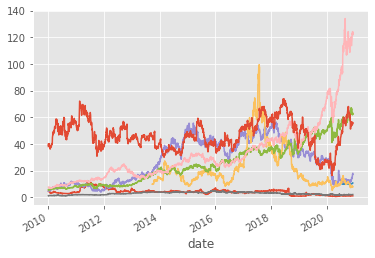

In [ ]:
current = os.getcwd()
model_path = os.path.join(currentdir, "LOOP_PPO2_MlpPolicy_NORM.zip")

for filename in os.listdir(current):
    #extract pretrain file
    if filename.endswith(".npz"):
      # get symbol-name
      x = filename.split("expert_trader_")
      x= x[1].split(".npz")
      symbol=x[0]

      f = open('traing_progress.txt', 'a')
      f.write("pre-train: " + symbol)
      f.close()
      
      # create env
      quotes = download_data(symbol=symbol, start_date=start_date, end_date=end_date,plot=True)
      data = add_custom_ta_features(quotes,"open","high","low","close", fillna=True)
      env = create_trade_env(quotes, data,symbol)
      VecEnv = DummyVecEnv([lambda: create_trade_env(quotes, data,symbol)])

      if os.path.isfile(model_path):
        #load agent
        agent = PPO2.load(load_path=model_path, env=VecEnv,tensorboard_log=os.path.join(currentdir,"logs"))
        print("Agent has been loaded: Symbol= ", symbol)
        
      else:
        #create new agent
        agent = PPO2(policy=MlpPolicy, env=VecEnv, verbose=1,tensorboard_log=os.path.join(currentdir,"logs"))
        print("new Agent has been created: Symbol= ", symbol)

      # Pretrain the PPO2 model
      dataset = ExpertDataset(expert_path='expert_trader_'+ symbol +'.npz',
                              traj_limitation=10, batch_size=64, randomize = False)      
      agent.pretrain(dataset, n_epochs=100)

      # As an option, you can train the RL agent
      agent.learn(int(1e4),tb_log_name="learn_"+symbol)
      
      #save Model
      agent.save(save_path=model_path)
      print("Agent has been Saved: Symbol= ", symbol)
      print("--------------------------------------------------")


    else:
        continue

In [ ]:
VecEnv = DummyVecEnv([lambda: create_trade_env(quotes, data,symbol)])

#agent = DQN.load(load_path=os.path.join(currentdir, "agents","DQN_MlpPolicy_02.zip"), env=env)
evaluate_model(agent, env)

In [ ]:
agent = PPO2.load(load_path=os.path.join(currentdir, "BC_PPO2_MlpPolicy_NORM.zip"))
# Pretrain the PPO2 model
agent.pretrain(dataset, n_epochs=1000)

# As an option, you can train the RL agent
agent.learn(int(1e5),tb_log_name="learn_"+symbol)

# Evaulate using Pyfolio

In [ ]:
    rets = px[['AdjClose']]
    rets = rets.shift(-1)
    rets.iloc[-1]['AdjClose'] = px.tail(1)['AdjOpen']
    rets = rets.shift(1) / rets - 1
    rets = rets.dropna()
    rets.index = rets.index.to_datetime()
    rets.index = rets.index.tz_localize("UTC")
    rets.columns = [symbol]
    return rets